In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import json
import pickle
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [3]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df.replace({'weekday':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    clean_df_freq = clean_df.asfreq('H')
    
    return clean_df_freq

### df with secondary band, spot price and demand 

In [5]:
raw_band_price = pd.read_csv('2014_2016_training_files/export_PrecioBandaDeRegulaciónSecundaria_2017-01-15_19-11.csv', encoding='latin1', delimiter=';')
band_price = get_clean_data(raw_band_price)
band_price = band_price.rename(columns={'value':'band'})

In [4]:
raw_spot_price = pd.read_csv('2014_2016_training_files/export_PrecioMercadoSPOTDiario_2017-02-02_09-47.csv', encoding='latin1', delimiter=';')
raw_spot_price = raw_spot_price[raw_spot_price['geoid'] == 3]
spot_price = get_clean_data(raw_spot_price)
spot_price = spot_price.rename(columns={'value':'spot'})

In [5]:
raw_demand = pd.read_csv('2014_2016_training_files/export_DemandaProgramada_2017-02-02_09-45.csv', encoding='latin1', delimiter=';')
demand = get_clean_data(raw_demand)
demand = demand.rename(columns={'value':'demand'})

In [6]:
spot_band_demand = band_price.merge(spot_price[['spot']], how='left', left_index=True, right_index=True)
spot_band_demand = spot_band_demand.merge(demand[['demand']], how='left', left_index=True, right_index=True)

In [7]:
spot_band_demand = spot_band_demand[['hour', 'weekday', 'season', 'spot','demand', 'band']]

In [8]:
for feature in ['hour', 'weekday', 'season']:
    spot_band_demand[pd.get_dummies(spot_band_demand[feature], drop_first=True).columns.tolist()] = pd.get_dummies(spot_band_demand[feature], drop_first=True)

In [9]:
for feature in ['demand', 'spot']:
    spot_band_demand[feature + '-1'] = spot_band_demand[feature].shift(periods=+1)
    spot_band_demand[feature + '-24'] = spot_band_demand[feature].shift(periods=+24)
spot_band_demand['band-24'] = spot_band_demand['band'].shift(periods=24)
spot_band_demand.dropna(subset=['demand-1', 'spot-1', 'demand-24', 'spot-24', 'band-24'], inplace=True)

### Preprocessing for Decision Tree

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import tree as tree_m
from sklearn.tree import export_graphviz
import graphviz

In [11]:
#Set features and output
X = spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).values
Y = spot_band_demand['band'].values

In [12]:
spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).corr()

,spot,demand,off_peak,Wd,winter,demand-1,demand-24,spot-1,spot-24,band-24
spot,1.000000,0.439271,-2.782497e-01,2.362048e-01,-3.455513e-02,0.404751,0.329684,0.966815,0.775220,-0.293587
demand,0.439271,1.000000,-6.632193e-01,3.911550e-01,8.202220e-02,0.950713,0.811719,0.418458,0.330222,-0.304035
off_peak,-0.278250,-0.663219,1.000000e+00,8.301321e-17,3.785815e-17,-0.630145,-0.662662,-0.259829,-0.277380,0.298587
Wd,0.236205,0.391155,8.301321e-17,1.000000e+00,-3.754593e-03,0.386605,0.060692,0.234965,0.021821,-0.031532
winter,-0.034555,0.082022,3.785815e-17,-3.754593e-03,1.000000e+00,0.081945,0.081045,-0.034386,-0.029929,0.135055
demand-1,0.404751,0.950713,-6.301450e-01,3.866047e-01,8.194535e-02,1.000000,0.772684,0.439311,0.303557,-0.281814
demand-24,0.329684,0.811719,-6.626618e-01,6.069245e-02,8.104539e-02,0.772684,1.000000,0.313280,0.440859,-0.402910
spot-1,0.966815,0.418458,-2.598290e-01,2.349651e-01,-3.438614e-02,0.439311,0.313280,1.000000,0.761822,-0.281421
spot-24,0.775220,0.330222,-2.773799e-01,2.182063e-02,-2.992868e-02,0.303557,0.440859,0.761822,1.000000,-0.481855
band-24,-0.293587,-0.304035,2.985872e-01,-3.153192e-02,1.350551e-01,-0.281814,-0.402910,-0.281421,-0.481855,1.000000


In [13]:
features_list = spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).columns.tolist()

In [14]:
#Split data set into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, 
                                                    test_size=0.2, random_state=1)

### Randomized Search CV

In [15]:
params = {
    'criterion':['mse'],
    'splitter':['best','random'],
    'max_features':['auto','log2', 'sqrt'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [16]:
#Random search, set up tree and cross-validation
tree = DecisionTreeRegressor()
kf = KFold(n_splits=5)

#Randomized Search CV for tree
random_search = RandomizedSearchCV(tree, param_distributions=params, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [17]:
random_search.fit(x_train, y_train);

In [18]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'max_features': 'auto', 'splitter': 'best', 'max_leaf_nodes': 140, 'min_samples_split': 408, 'criterion': 'mse', 'max_depth': 6, 'min_samples_leaf': 293}


In [19]:
tree.set_params(**best_params, random_state=0)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='auto',
           max_leaf_nodes=140, min_impurity_split=1e-07,
           min_samples_leaf=293, min_samples_split=408,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [20]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    tree.fit(x_train[train_index], y_train[train_index])
    y_pred = tree.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 5.6245 +- 0.1562
Mean squared error: 70.6660 +- 7.2539


In [21]:
CV_mae, CV_mse

([5.6483176367792698,
  5.6516878706406395,
  5.6524523246030265,
  5.4724808518472141,
  5.6973343740178857],
 [73.044985030447634,
  73.73185483890316,
  68.649118572286881,
  64.436846099798984,
  73.46695041432325])

In [22]:
tree.fit(x_train, y_train)
print('MAE: ' +str(mean_absolute_error(y_train, tree.predict(x_train)))+', MSE: ' +
      str(mean_squared_error(y_train, tree.predict(x_train))))

MAE: 5.4443461512, MSE: 66.5193109854


In [23]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, tree.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, tree.predict(x_test))))
pd.DataFrame(data=tree.feature_importances_, index=features_list)

MAE: 5.64976678096, MSE: 67.2140913528


,0
spot,0.257636
demand,0.041164
off_peak,0.002279
Wd,0.025763
winter,0.000000
demand-1,0.000000
demand-24,0.012536
spot-1,0.000000
spot-24,0.068105
band-24,0.592516


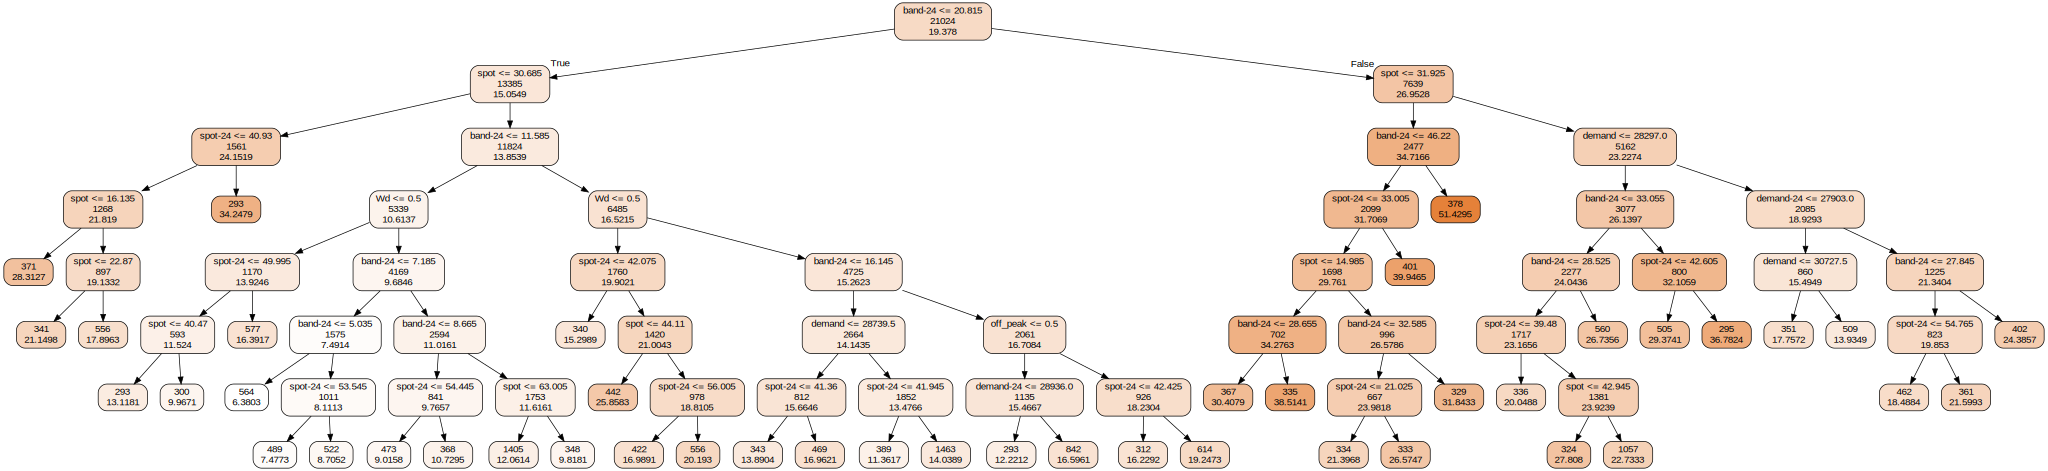

In [24]:
#Plot tree with graphviz
export_graphviz(tree, out_file="mytree.dot", max_depth=None, feature_names=features_list, label='none',
               filled=True, leaves_parallel=False, impurity=False, node_ids=False, proportion=False, rotate=False,
               rounded=True, special_characters=False)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [25]:
#Convert tree.dot into pdf
#graphviz.render(engine='dot', format='pdf', filepath='C:\\Users\\Usuario\\Desktop\\Master_Thesis\\Secondary_reserve_TS\\mytree.dot')

### Random forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
rfr = RandomForestRegressor()

In [28]:
params_forest = {
    'n_estimators':np.linspace(5, 200, 50).astype(int),
    'n_jobs':[-1],
    'criterion':['mse'], 'bootstrap':[True],
    'max_features':['log2', 'sqrt'],
    'max_depth':np.arange(2,10), 'min_samples_split':np.linspace(50, 1000, 200).astype(int),
    'min_samples_leaf': np.linspace(200, 2500, 50).astype(int), 'max_leaf_nodes': np.linspace(10,180, 40).astype(int)
}

In [29]:
kf = KFold(n_splits=5, random_state=0)

#Randomized Search CV for random forest
random_search = RandomizedSearchCV(rfr, param_distributions=params_forest, n_jobs=-1, n_iter=350,
                                scoring='neg_mean_squared_error', cv=list(kf.split(x_train,y_train)), random_state=0)

In [30]:
%%time
random_search.fit(x_train, y_train);

Wall time: 7min 17s


RandomizedSearchCV(cv=[(array([ 4205,  4206, ..., 21022, 21023]), array([   0,    1, ..., 4203, 4204])), (array([    0,     1, ..., 21022, 21023]), array([4205, 4206, ..., 8408, 8409])), (array([    0,     1, ..., 21022, 21023]), array([ 8410,  8411, ..., 12613, 12614])), (array([    0,     1, ..., 21022, 21023]), array([12615, 12616, ..., 16818, 16819])), (array([    0,     1, ..., 16818, 16819]), array([16820, 16821, ..., 21022, 21023]))],
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=350, n_jobs=-1,
          param_distributions={'max_features': ['log2', 'sqrt'], 'max_leaf_nodes': arra

In [31]:
best_params = random_search.cv_results_['params'][np.flatnonzero(random_search.cv_results_['rank_test_score']==1)[0]]
print(best_params)

{'max_features': 'log2', 'max_leaf_nodes': 136, 'n_estimators': 80, 'min_samples_split': 183, 'bootstrap': True, 'criterion': 'mse', 'max_depth': 9, 'n_jobs': -1, 'min_samples_leaf': 200}


In [32]:
rfr.set_params(**best_params, random_state=0)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=136,
           min_impurity_split=1e-07, min_samples_leaf=200,
           min_samples_split=183, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [33]:
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    rfr.fit(x_train[train_index], y_train[train_index])
    y_pred = rfr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 5.5691 +- 0.1535
Mean squared error: 69.2693 +- 5.7433


In [34]:
CV_mae, CV_mse

([5.561221239518999,
  5.5110105539618326,
  5.6262434883880177,
  5.4669523694393183,
  5.6801075998935513],
 [71.074514994109478,
  70.197814284363332,
  66.747460136650858,
  65.243620967228424,
  73.08316658146407])

In [35]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=136,
           min_impurity_split=1e-07, min_samples_leaf=200,
           min_samples_split=183, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [36]:
print('Training MAE: ' +str(mean_absolute_error(y_train, rfr.predict(x_train)))+', Training MSE: ' +
      str(mean_squared_error(y_train, rfr.predict(x_train))))

Training MAE: 5.38882609315, Training MSE: 65.1915876315


In [37]:
#Print test error and feature importance
print('MAE: ' +str(mean_absolute_error(y_test, rfr.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, rfr.predict(x_test))))
pd.DataFrame(data=rfr.feature_importances_, index=features_list)

MAE: 5.51891621919, MSE: 63.4837158074


,0
spot,0.182390
demand,0.107564
off_peak,0.019136
Wd,0.012870
winter,0.015531
demand-1,0.042156
demand-24,0.010987
spot-1,0.136388
spot-24,0.044417
band-24,0.428561


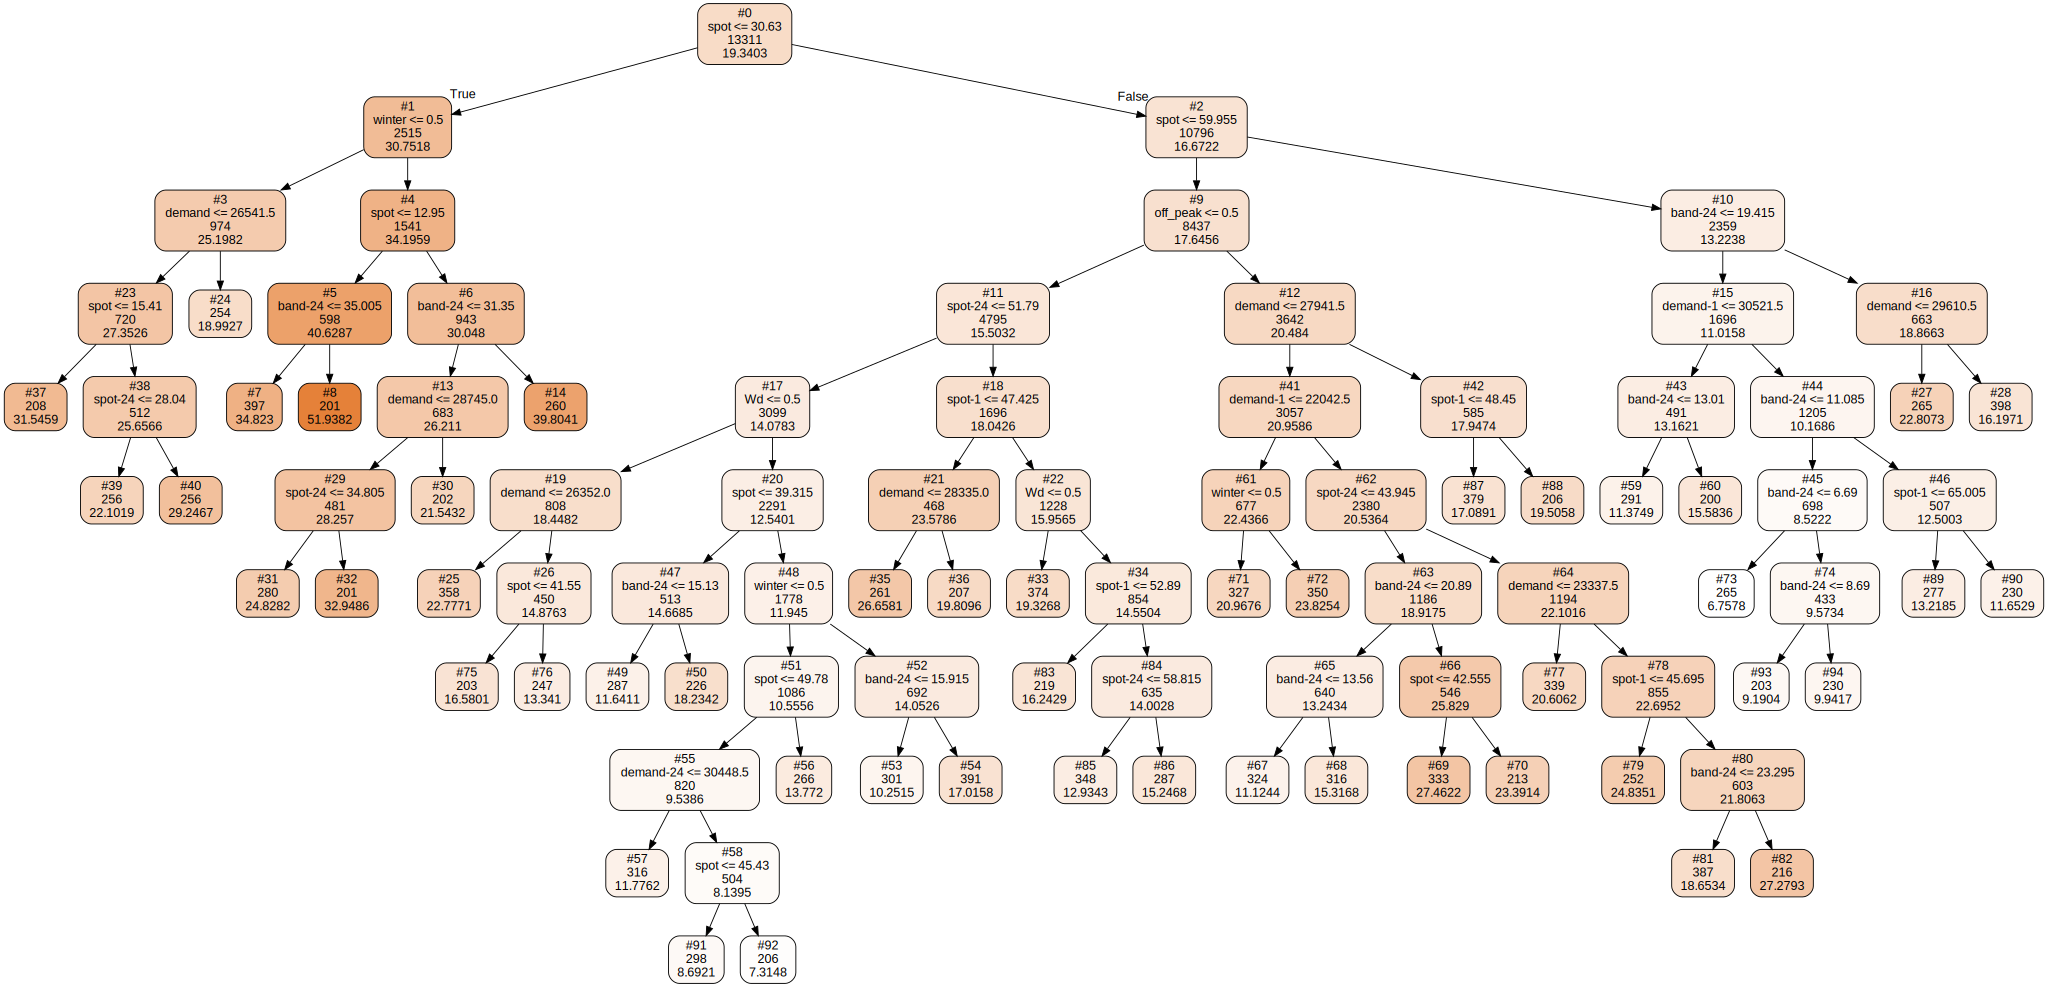

In [38]:
export_graphviz(rfr.estimators_[12], out_file="0.dot", max_depth=None, feature_names=features_list, label='none',
               filled=True, leaves_parallel=False, impurity=False, node_ids=True, proportion=False, rotate=False,
               rounded=True, special_characters=False)
with open("0.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [39]:
# Customised random forest, this is the final model
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=130,
           min_impurity_split=1e-07, min_samples_leaf=250,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [40]:
rfr.fit(x_train, y_train)
#CV with kfold=5
kf = KFold(n_splits=5, random_state=0)

CV_mse = list()
CV_mae = list()

for train_index, test_index in kf.split(x_train, y_train):
    rfr.fit(x_train[train_index], y_train[train_index])
    y_pred = rfr.predict(x_train[test_index])
    CV_mae.append(mean_absolute_error(y_train[test_index], y_pred))
    CV_mse.append(mean_squared_error(y_train[test_index], y_pred))
    
print('Mean absolute error: %0.4f +- %0.4f' %(np.mean(CV_mae), 2*np.std(CV_mae)))
print('Mean squared error: %0.4f +- %0.4f' %(np.mean(CV_mse), 2*np.std(CV_mse)))

Mean absolute error: 5.6607 +- 0.1533
Mean squared error: 71.2615 +- 6.1246


In [41]:
CV_mae, CV_mse

([5.6552807005202128,
  5.6052862804133943,
  5.7059859110401927,
  5.5586898120609538,
  5.778325470229305],
 [73.146736876330706,
  72.158021729650969,
  68.624229840367093,
  66.972320261247717,
  75.406169363893014])

In [42]:
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='log2', max_leaf_nodes=130,
           min_impurity_split=1e-07, min_samples_leaf=250,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [43]:
print('Training MAE: ' +str(mean_absolute_error(y_train, rfr.predict(x_train)))+', Training MSE: ' +
      str(mean_squared_error(y_train, rfr.predict(x_train))))

Training MAE: 5.508771271, Training MSE: 67.7326390798


In [44]:
print('MAE: ' +str(mean_absolute_error(y_test, rfr.predict(x_test)))+', MSE: ' +
      str(mean_squared_error(y_test, rfr.predict(x_test))))
pd.DataFrame(data=rfr.feature_importances_, index=features_list)

MAE: 5.63210064918, MSE: 65.8646996199


,0
spot,0.183870
demand,0.112686
off_peak,0.019808
Wd,0.012148
winter,0.015286
demand-1,0.042858
demand-24,0.009177
spot-1,0.136489
spot-24,0.036785
band-24,0.430893


In [45]:
#Transform y_true and y_pred from last model into log scale for the residual fitting
rfr.fit(X, Y)
Y_log = np.log1p(Y)
Y_pred_log = np.log1p(rfr.predict(X))
residuals = Y_log - Y_pred_log
res_index = spot_band_demand.drop(labels=['hour', 'weekday','season', 'band'], axis=1).index
residuals_random_forest = pd.DataFrame(data=residuals, index=res_index, columns=['residuals'])
residuals_random_forest.to_csv('Residuals_from_random_forest.csv')

In [ ]:
#Save fitted model into a pickle
with open('random_forest_p', 'wb') as f:
    pickle.dump(rfr, f)